In [50]:
%matplotlib  inline
import matplotlib.pyplot as plt
import numpy as np
from pyPCGA import PCGA
import mf
import math
import datetime as dt
import pandas as pd  
import flopy
import flopy.utils.binaryfile as bf
import os

In [51]:
# params to pass to Model class
delr = 169 
delc = 165
nlay = 1
nrow = 100
ncol = 200
botm = -1250

In [52]:
# Pre-development water levels spreadsheet. Compiled from drillers logs and pump tests
# monitoring well data from this  integrated framework. 
MON_WELL_MEASUREMENT_SHEET = os.path.join("..", "..", "..",  "ASPA-UH_MonWells", "workspace", "Ave_WL_MSL_m_mon_wells.csv")

# PREDEVELOP_WLS_2_CSV = os.path.join(".", "GIS_Data", 'Predevelop_WLs_w_fake_pts.csv')   # using fake points n outside of domain
PREDEVELOP_WLS_2_CSV = os.path.join("..", "..", 'Static_Data_Storage', 'GIS','Predevelop_WLs_2.csv')

Pdevel_WLs = pd.read_csv(PREDEVELOP_WLS_2_CSV)

xll = 515244    # hard code too
yll = 8410178

# Just stick on the data from the measured monitoring wells (it will average both values if repeated)
Mon_well_WLs = pd.read_csv(MON_WELL_MEASUREMENT_SHEET) 
del Mon_well_WLs['Well_num']
Pdevel_WLs = Pdevel_WLs.append(Mon_well_WLs, sort=False)

Pdevel_WLs['row_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate 
Pdevel_WLs['col_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['col_num'].astype(int))
colvals = list(Unique_WLs['row_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

obs_locmat = np.asarray(obsvals)

In [53]:
mf_params = {'layervals': layervals, 'rowvals': rowvals,
          'colvals': colvals, 'obsvals':obsvals, 'obsnames':obsnames, 'nobs':nobs,
          'delr': delr, 'delc': delc,
          'nlay': nlay, 'nrow': nrow, 'ncol': ncol,
          'botm': botm, 'obs_locmat': obs_locmat} 

In [54]:
def forward_model(s, parallelization, ncores=None):
    model = mf.Model(mf_params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
        
    return simul_obs

In [114]:
## From Harrys code 
N = np.array([ncol, nrow, nlay])
m = np.prod(N)
Lx = delc*ncol
Ly = delr*nrow
Lz = abs(botm)
dx = np.array([delc, delr, abs(botm)])
xmin = np.array([0. + dx[0] / 2., 0. + dx[1] / 2., 0. + dx[2] / 2.])
xmax = np.array([Lx - dx[0] / 2., Ly - dx[1] / 2., Lz - dx[2] / 2.])


prior_std = 1.0
prior_cov_scale = np.array([5.5, 5.5, 1.])

def kernel(r): return (prior_std ** 2) * np.exp(-r)

obs = obs_locmat


params = {'R': (0.5) ** 2, 'n_pc': 50,
          'maxiter': 10, 'restol': 0.01,
          'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
          'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
          'kernel': kernel, 'post_cov': "diag",
          'precond': True, 'LM': True,
          'parallel': True, 'linesearch': True,
          'forward_model_verbose': False, 'verbose': False,
          'iter_save': True}


s_init = np.ones((m, 1))


x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

In [115]:
prob = PCGA(forward_model, s_init, pts, params, s_true=None, obs=obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 20000
   Number of observations                           : 208
   Number of principal components (n_pc)            : 50
   Prior model                                      : def kernel(r): return (prior_std ** 2) * np.exp(-r)

   Prior variance                                   : 1.000000e+00
   Prior scale (correlation) parameter              : [5.5 5.5 1. ]
   Posterior cov computation                        : diag
   Posterior variance computation                   : Direct
   Number of CPU cores (n_core)                     : 4
   Maximum GN iterations                            : 10
   machine precision (delta = sqrt(precision))      : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-02
   Levenberg-Marquardt (LM)                         : True
   LM solution ra

In [116]:
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 20000) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 80 sec
- 1st eigv : 1, 50-th eigv : 1, ratio: 1
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 587.823, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 1175.65
***** Iteration 1 ******
computed Jacobian-Matrix products in 17.361066 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
LM solution evaluted
- Geostat. inversion at iteration 1 is 20 sec
== iteration 1 summary ==
= objective function is 1.437403e+08, relative L2-norm diff btw sol 0 and sol 1 is 0.501194
= obs. RMSE is 587.816, obs. normalized RMSE is 1175.63
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 16.562052 secs
solve saddle point (co-kriging) systems with Levenbe

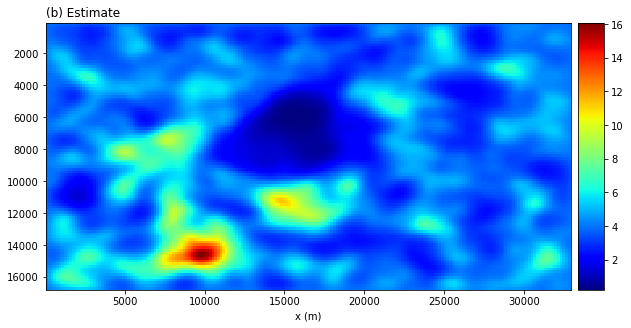

In [117]:
# plot the HK field
s_hat3d = s_hat.reshape(nlay, nrow, ncol)
s_hat2d = s_hat3d[0,:,:]
s_hat2d = np.exp(s_hat2d)   # do I need to transform this???

minv = s_hat2d.min()
maxv = s_hat2d.max()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, s_hat2d, vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Estimate', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

In [118]:
# just for now export the HK array to a txt 

s_hat_adjusted = s_hat2d
np.savetxt(os.path.join(".", "s_hat_adjusted9.txt"), s_hat_adjusted)

In [119]:
mf_params = {'layervals': layervals, 'rowvals': rowvals,
          'colvals': colvals, 'obsvals':obsvals, 'obsnames':obsnames, 'nobs':nobs,
          'delr': delr, 'delc': delc,
          'nlay': nlay, 'nrow': nrow, 'ncol': ncol,
          'botm': botm, 'obs_locmat': obs_locmat, 'deletedir':False} 

#comp_obs = forward_model(np.exp(np.log(s_hat)), 0)
comp_obs = forward_model(s_hat, 0)

FloPy is using the following  executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/09/12 17:04:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground-Water Flow Eqn.


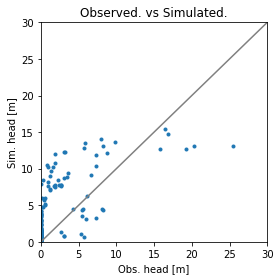

Mean Error: 344.84
Mean Absolute Error: 350.13
RMS Error: 589.11


In [120]:
obs_obs = obs_locmat
residuals = obs_obs - comp_obs

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(obs_obs, comp_obs, '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,30)
plt.xlim(0,30)

plt.plot([0,20,30],[0,20,30], color= "grey")
plt.tight_layout()


plt.show()

me = np.mean(residuals)
mea = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

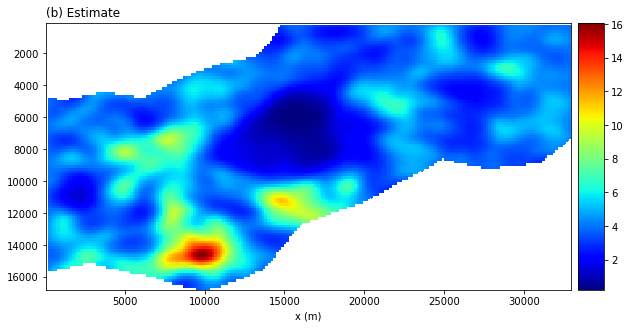

In [121]:
txtspace = os.path.join('Txt_inputs')
final_ibound = np.loadtxt(os.path.join(txtspace,  "final_ibound.txt"))
mask = abs(final_ibound-1)
masked_sim_hk = np.ma.masked_array(s_hat2d, mask)



minv = masked_sim_hk.min()
maxv = masked_sim_hk.max()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, masked_sim_hk, vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Estimate', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

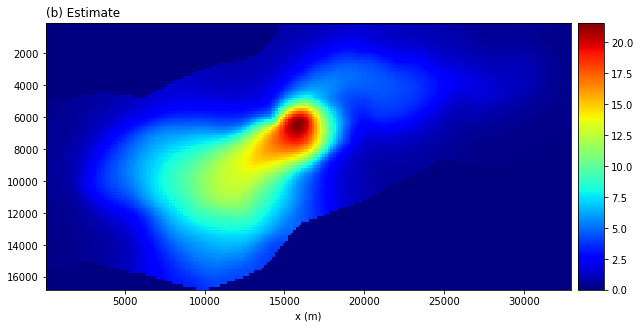

In [122]:
# Post heads to graph the results


hds = bf.HeadFile(os.path.join(".", "simul", "simul0000", '{}.hds'.format("mf")))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])

minv = 0
maxv = head.max()


fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Estimate', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()